In [1]:
import os
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D,PReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import  confusion_matrix,precision_score,accuracy_score,recall_score,ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
import pandas as pd

In [2]:
URL="./Videos"


In [3]:
metricas={"precision":[],"recall":[]}

## Funciones definidas

In [4]:
def obtenerDatos(archivo):
   data=h5py.File(archivo)
   return data["X"][:],data["Y"][:] 

In [5]:
def obtener_etiquetas(url):
    labels=[]
    for index,carpeta in enumerate(os.listdir(str(url))):
        labels.append(carpeta)
    return labels

In [6]:
def normalizar(X):
    return X/255.0


In [7]:
def redimensionarData(X,ancho,largo,num_canales):
    imagenes=[]
    for imagen in X:
        img=imagen
        img=cv2.resize(img, (ancho, largo), interpolation=cv2.INTER_AREA)
        if(num_canales==1):
            img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis=-1) 

        imagenes.append(img)
    return np.array(imagenes)


In [8]:
def plot_image(image):
    plt.imshow(image, cmap = "gray", interpolation = "nearest")
    plt.axis("off")

## Cargamos los datos

In [9]:
X_train,y_train=obtenerDatos("./data/datos_train_color.h5")


## Data augmentation

In [ ]:
import cv2
import numpy as np

def augment_image(image):
    # Rotación
    angle = np.random.uniform(-30, 30)  
    center = (image.shape[1] // 2, image.shape[0] // 2) 
    M_rotation = cv2.getRotationMatrix2D(center, angle, 1) 
    rotated = cv2.warpAffine(image, M_rotation, (image.shape[1], image.shape[0]))  

    flipped = cv2.flip(rotated, 1) if np.random.rand() > 0.5 else rotated

    scale_factor = np.random.uniform(0.8, 1.2)  
    scaled = cv2.resize(flipped, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
    if scale_factor != 1.0:  
        h, w = image.shape[:2]
        start_x = max((scaled.shape[1] - w) // 2, 0)
        start_y = max((scaled.shape[0] - h) // 2, 0)
        scaled = scaled[start_y:start_y+h, start_x:start_x+w]
        if scaled.shape[:2] != (h, w):
            scaled = cv2.resize(scaled, (w, h)) 

    # Desplazamiento (Translation)
    tx = np.random.uniform(-30, 30) 
    ty = np.random.uniform(-30, 30)  
    M_translation = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(scaled, M_translation, (image.shape[1], image.shape[0]))

    # Corte y redimensionamiento
    h, w = translated.shape[:2]
    crop_x = np.random.randint(0, w // 4)
    crop_y = np.random.randint(0, h // 4)
    cropped = translated[crop_y:h-crop_y, crop_x:w-crop_x]
    cropped_resized = cv2.resize(cropped, (w, h))

    # Ruido
    noise = np.random.normal(0, 10, cropped_resized.shape)  
    noisy_image = np.clip(cropped_resized + noise, 0, 255).astype(np.uint8)  

    return noisy_image

In [ ]:
X_augmented = np.array([augment_image(img) for img in X_train])

In [ ]:
X_train= np.vstack([X_train, X_augmented])
y_train= np.hstack([y_train, y_train])  


In [13]:
X_test,y_test=obtenerDatos("./data/datos_test_color.h5")


In [14]:
X_train.shape

(4800, 200, 200, 3)

In [15]:
y_train.shape

(4800,)

In [16]:
X_test.shape

(800, 200, 200, 3)

In [17]:
y_test.shape

(800,)

## Visualizamos la data

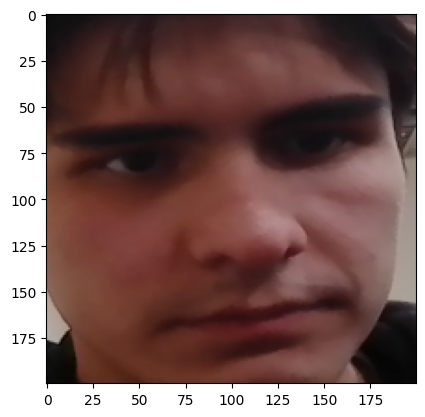

In [18]:
plt.imshow(X_train[1202])

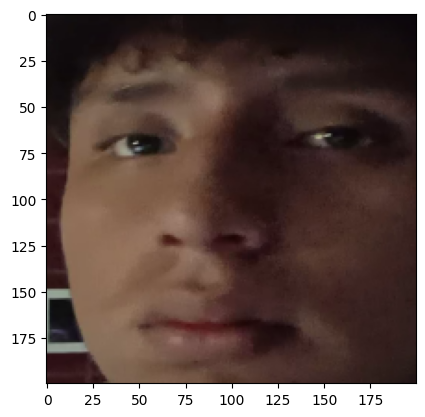

In [19]:
plt.imshow(X_train[500])

In [20]:
labels=[]

In [21]:
labels=['Agus', 'Ale', 'Noni', 'Sebas']

In [22]:
labels

['Agus', 'Ale', 'Noni', 'Sebas']

## Modelo Generico

In [23]:
class ModeloPersonalizado:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.modelo = None
        self.historial = None
        self.predicciones = None
        self.matriz_confusion = None

    def construir_modelo(self, configuracion):
        self.modelo = Sequential()
        self.modelo.add(InputLayer(input_shape=self.input_dim))

        # agregamos las capas convolucionales
        for capa in configuracion["capas_convolucionales"]:
            if capa["activation"]=="prelu":
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"]))
                self.modelo.add(PReLU())
            else:
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"], activation=capa["activation"]))
            if "max_pooling" in capa:
                self.modelo.add(MaxPooling2D(pool_size=capa["max_pooling"]))
            elif  "avg_pooling" in capa:
                self.modelo.add(AveragePooling2D(pool_size=capa["avg_pooling"]))

        self.modelo.add(Flatten())

        # agregamos capas densas
        for capa in configuracion["capas_ocultas"]:
            if capa["activation"]=="prelu":
                    self.modelo.add(tf.keras.layers.Dense(capa["neuronas"]))
                    self.modelo.add(tf.keras.layers.PReLU())
            else:
                self.modelo.add(Dense(capa["neuronas"], activation=capa["activation"]))
            if "dropout" in capa and capa["dropout"] > 0:
                self.modelo.add(Dropout(capa["dropout"]))

        self.modelo.add(Dense(self.output_dim, activation="softmax"))

    def compilar_modelo(self, learning_rate):
        optimizer = Nadam(learning_rate=learning_rate)
        self.modelo.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    def entrenar_modelo(self, X_train, y_train, X_val, y_val, epochs, factor_reduccion, paciencia):
        """
        Un callback en Keras es un conjunto de funciones que puedes usar para personalizar y controlar el proceso de entrenamiento del modelo
        ReduceLROnPlateau es un callback en Keras que se utiliza para reducir la tasa de aprendizaje (learning rate)
        automáticamente si una métrica(val_loss) no mejora después de un número definido de épocas (patience).
        min_lr:El learning rate no se reducirá por debajo de este valor, lo que previene que se acerque a cero.
        lr_scheduler=planificador de la tasa de aprendizaje

        Todo este trabajo se hace poruqe la tasa de aprendizaje se encarga de enontrar el j mas pequeno para los thetas
        si este j o en nuestro caso el val_loss ya no baja mucho o de la nada se subio su valor que posiblemente estemos cerca al mejor
        j o val_loss posible para los tethas y nos conviende dar pasitos mas cortos en la tasa de aprendizaje cuidando de que no sea cero con 
        min_lr
        """
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss",
            factor=factor_reduccion,
            patience=paciencia,
            verbose=1,
            min_lr=1e-6
        )

        self.historial = self.modelo.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler], 
            verbose=1
        )

    def evaluar_modelo(self, X_test, y_test, labels, configuracion):
        probabilidades = self.modelo.predict(X_test)
        self.predicciones = np.argmax(probabilidades, axis=1)

        #El macro average calcula la precisión y el recall de forma independiente para cada clase. Luego toma el promedio aritmético de esas métricas.
        precision = precision_score(y_test, self.predicciones, average="macro")
        recall = recall_score(y_test, self.predicciones, average="macro")

        self.matriz_confusion = confusion_matrix(y_test, self.predicciones)

        resultados = {
            "configuracion": configuracion,
            "precision": precision,
            "recall": recall,
            "historial": self.historial.history,
            "matriz_confusion": self.matriz_confusion
        }

        return resultados

## Configramos los modelos

In [24]:
configuraciones=[ 
    ## CNN BASICA
    {
       
        "input_dims":  (32,32,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(2,2)
           },
           {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 128, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
        {
       
        "input_dims":  (32,32,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"prelu",
           "max_pooling":(2,2)
           },
           {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"prelu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 128, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    ## CNN Imagenes Grandes
    {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"relu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "relu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
        {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"prelu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"prelu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "prelu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


    ## CNN Profunda
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "relu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "prelu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


    ## CNN Imagenes Grandes sin DropOut
    {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"relu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"prelu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"prelu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


    ## CNN Profunda Sin Dropout
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


]

In [25]:

resultados_metricas = []

for idx, config in enumerate(configuraciones):
    print(f"Entrenando modelo {idx + 1}/{len(configuraciones)}...")
    input_dims=config["input_dims"]
    X_train_copia=X_train.copy()
    X_test_copia=X_test.copy()
    X_train_copia=normalizar(X_train_copia)
    X_test_copia=normalizar(X_test_copia)
    X_train_copia=redimensionarData(X_train_copia,*input_dims)
    X_test_copia=redimensionarData(X_test_copia,*input_dims)
    print(X_train_copia.shape)
    print(X_test_copia.shape)
    

    modelo = ModeloPersonalizado(input_dim=input_dims, output_dim=4)
    modelo.construir_modelo(config)
    modelo.compilar_modelo(learning_rate=config["learning_rate"])
    modelo.entrenar_modelo(
        X_train=X_train_copia,
        y_train=y_train,
        X_val=X_test_copia,
        y_val=y_test,
        epochs=30,
        factor_reduccion=config["factor_reduccion"],
        paciencia=5,
    )
    
    resultados = modelo.evaluar_modelo(
        X_test=X_test_copia,
        y_test=y_test,
        labels=labels,
        configuracion=config
    )
    resultados_metricas.append(resultados)

    print(f"Modelo {idx + 1} se acabo de entrenar y se guardo")

df_resultados = pd.DataFrame(resultados_metricas)


Entrenando modelo 1/10...
(4800, 32, 32, 3)
(800, 32, 32, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6401 - loss: 0.7931 - val_accuracy: 0.6438 - val_loss: 2.7452 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9606 - loss: 0.1177 - val_accuracy: 0.6025 - val_loss: 2.5408 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9802 - loss: 0.0669 - val_accuracy: 0.6725 - val_loss: 3.1232 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9859 - loss: 0.0421 - val_accuracy: 0.6025 - val_loss: 3.3152 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9870 - loss: 0.0316 - val_accuracy: 0.4112 - val_loss: 3.4134 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9924 - loss: 0.0236 - val_accuracy: 0.6463 - val_loss: 3.7516 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9943 - loss: 0.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 3)
(800, 32, 32, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6235 - loss: 0.8328 - val_accuracy: 0.4487 - val_loss: 3.6789 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9678 - loss: 0.1002 - val_accuracy: 0.4825 - val_loss: 3.1275 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9835 - loss: 0.0547 - val_accuracy: 0.2575 - val_loss: 4.2212 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9877 - loss: 0.0407 - val_accuracy: 0.3375 - val_loss: 3.6580 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9928 - loss: 0.0236 - val_accuracy: 0.4500 - val_loss: 4.8027 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9938 - loss: 0.0206 - val_accuracy: 0.2988 - val_loss: 4.4348 - learning_rate: 0.0010
Epoch 7/30
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9966 - loss: 0.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 128, 128, 3)
(800, 128, 128, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.6284 - loss: 0.9306 - val_accuracy: 0.4613 - val_loss: 2.7898 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9742 - loss: 0.0826 - val_accuracy: 0.4387 - val_loss: 3.6029 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9776 - loss: 0.0641 - val_accuracy: 0.2612 - val_loss: 5.1279 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9881 - loss: 0.0308 - val_accuracy: 0.4187 - val_loss: 5.6851 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9898 - loss: 0.0307 - val_accuracy: 0.4263 - val_loss: 6.8037 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9851 - loss: 0.0498
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9852 - loss: 0.04

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo 3 se acabo de entrenar y se guardo
Entrenando modelo 4/10...
(4800, 128, 128, 3)
(800, 128, 128, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.5443 - loss: 1.1135 - val_accuracy: 0.6525 - val_loss: 1.3995 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9366 - loss: 0.1807 - val_accuracy: 0.6012 - val_loss: 2.2090 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.9782 - loss: 0.0607 - val_accuracy: 0.4938 - val_loss: 2.1788 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9933 - loss: 0.0234 - val_accuracy: 0.3300 - val_loss: 3.7602 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9810 - loss: 0.0569 - val_accuracy: 0.5562 - val_loss: 2.5464 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9927 - loss: 0.0244
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.9927 - loss: 0.02

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 64, 64, 3)
(800, 64, 64, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 143s 873ms/step - accuracy: 0.5611 - loss: 0.9954 - val_accuracy: 0.6263 - val_loss: 1.3635 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 855ms/step - accuracy: 0.9537 - loss: 0.1264 - val_accuracy: 0.5575 - val_loss: 2.7037 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 850ms/step - accuracy: 0.9760 - loss: 0.0785 - val_accuracy: 0.6825 - val_loss: 1.4463 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 830ms/step - accuracy: 0.9661 - loss: 0.1128 - val_accuracy: 0.6775 - val_loss: 2.0366 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 797ms/step - accuracy: 0.9845 - loss: 0.0449 - val_accuracy: 0.6862 - val_loss: 1.6358 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9928 - loss: 0.0221
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 ━━━━━━━━━━━━━━━━━━━━ 126s 845ms/step - accuracy

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 64, 64, 3)
(800, 64, 64, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5374 - loss: 1.0236 - val_accuracy: 0.5587 - val_loss: 2.3801 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9400 - loss: 0.1762 - val_accuracy: 0.6787 - val_loss: 3.9019 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9731 - loss: 0.0815 - val_accuracy: 0.4325 - val_loss: 3.3949 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9812 - loss: 0.0551 - val_accuracy: 0.4338 - val_loss: 5.5832 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9872 - loss: 0.0373 - val_accuracy: 0.4062 - val_loss: 7.4996 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9927 - loss: 0.0228
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9927 - loss: 0.02

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo 6 se acabo de entrenar y se guardo
Entrenando modelo 7/10...
(4800, 128, 128, 3)
(800, 128, 128, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.5625 - loss: 1.1876 - val_accuracy: 0.4062 - val_loss: 2.5621 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9685 - loss: 0.1085 - val_accuracy: 0.2825 - val_loss: 4.3747 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9536 - loss: 0.2168 - val_accuracy: 0.5800 - val_loss: 2.2271 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9560 - loss: 0.1247 - val_accuracy: 0.6137 - val_loss: 2.2247 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9834 - loss: 0.0467 - val_accuracy: 0.5525 - val_loss: 2.2839 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9896 - loss: 0.0302 - val_accuracy: 0.6087 - val_loss: 2.7614 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9904 - loss: 0.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 128, 128, 3)
(800, 128, 128, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.6314 - loss: 0.9837 - val_accuracy: 0.6837 - val_loss: 1.8201 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.9624 - loss: 0.1146 - val_accuracy: 0.6837 - val_loss: 2.0947 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9684 - loss: 0.0992 - val_accuracy: 0.6825 - val_loss: 2.0298 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.9933 - loss: 0.0237 - val_accuracy: 0.6862 - val_loss: 2.9898 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.9861 - loss: 0.0359 - val_accuracy: 0.6837 - val_loss: 3.1499 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9933 - loss: 0.0269
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9933 - loss: 0.02

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo 8 se acabo de entrenar y se guardo
Entrenando modelo 9/10...
(4800, 64, 64, 3)
(800, 64, 64, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 132s 855ms/step - accuracy: 0.5161 - loss: 1.0222 - val_accuracy: 0.5275 - val_loss: 3.3395 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 126s 844ms/step - accuracy: 0.9656 - loss: 0.0981 - val_accuracy: 0.4013 - val_loss: 6.5108 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 123s 822ms/step - accuracy: 0.9838 - loss: 0.0465 - val_accuracy: 0.4275 - val_loss: 6.4555 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 798ms/step - accuracy: 0.9874 - loss: 0.0339 - val_accuracy: 0.4400 - val_loss: 8.7013 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 126s 839ms/step - accuracy: 0.9902 - loss: 0.0244 - val_accuracy: 0.3713 - val_loss: 10.0371 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.9605 - loss: 0.1889
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 820ms/step - accurac

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 64, 64, 3)
(800, 64, 64, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.5492 - loss: 1.1747 - val_accuracy: 0.7188 - val_loss: 2.2213 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9467 - loss: 0.1478 - val_accuracy: 0.6913 - val_loss: 2.1570 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9817 - loss: 0.0653 - val_accuracy: 0.6975 - val_loss: 3.0160 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.9783 - loss: 0.0756 - val_accuracy: 0.4400 - val_loss: 3.4428 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.9943 - loss: 0.0157 - val_accuracy: 0.6837 - val_loss: 2.7158 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9968 - loss: 0.0112 - val_accuracy: 0.7100 - val_loss: 2.9082 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9878 - loss: 0.03

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo 10 se acabo de entrenar y se guardo


Modelo 1:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5498
Recall: 0.5625

Graficando historial de entrenamiento...


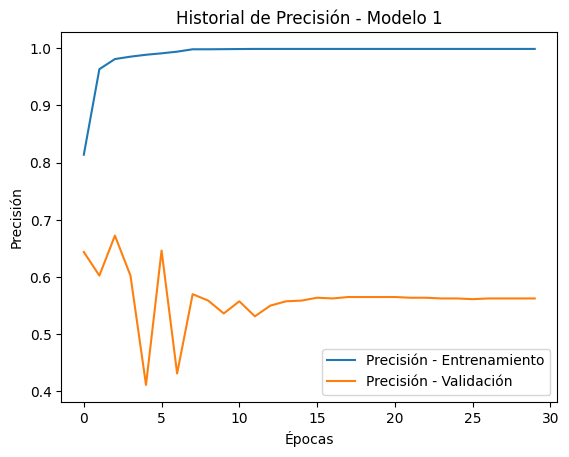

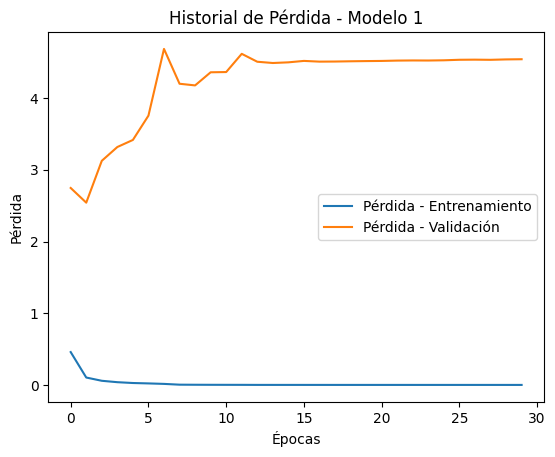


Matriz de Confusión:


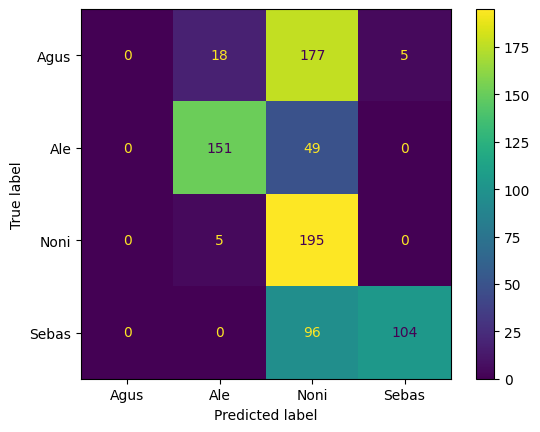



Modelo 2:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.3998
Recall: 0.3125

Graficando historial de entrenamiento...


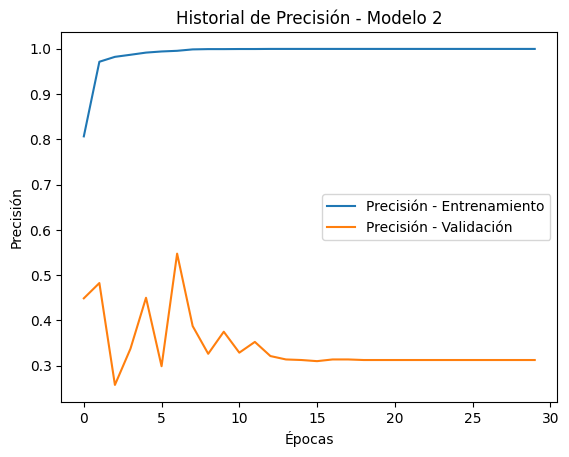

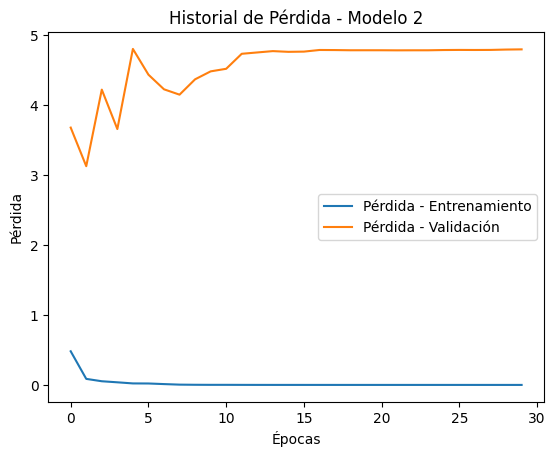


Matriz de Confusión:


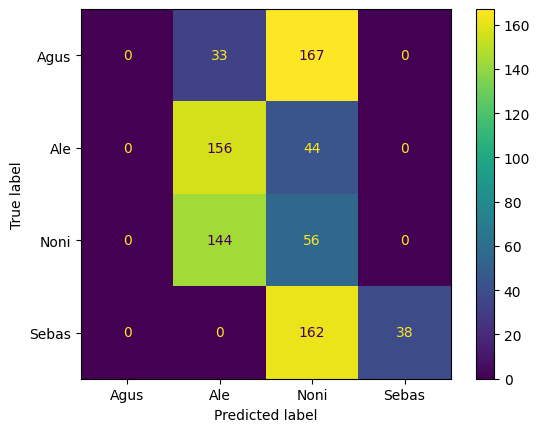



Modelo 3:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='relu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2141
Recall: 0.4188

Graficando historial de entrenamiento...


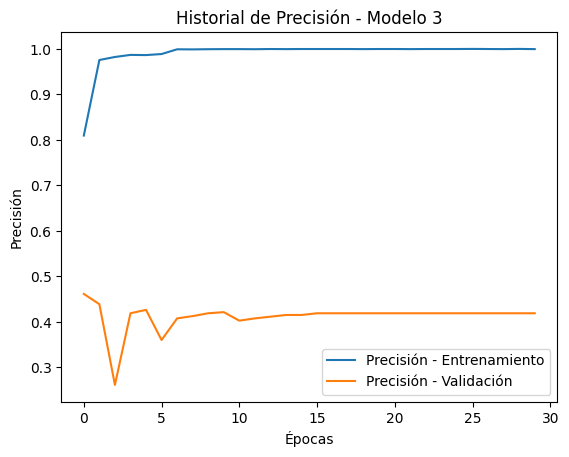

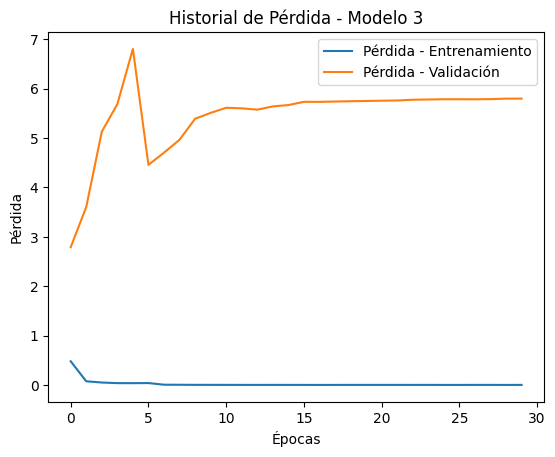


Matriz de Confusión:


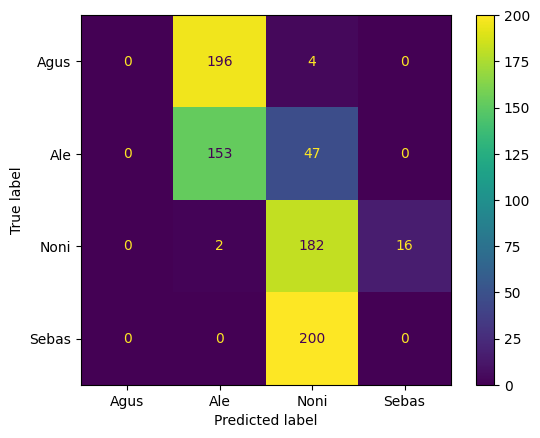



Modelo 4:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='prelu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.4852
Recall: 0.5088

Graficando historial de entrenamiento...


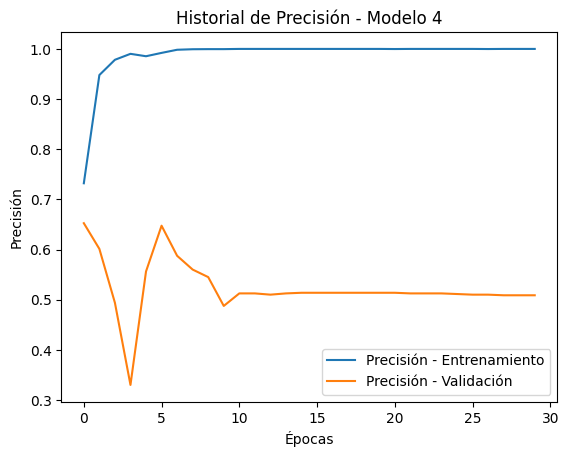

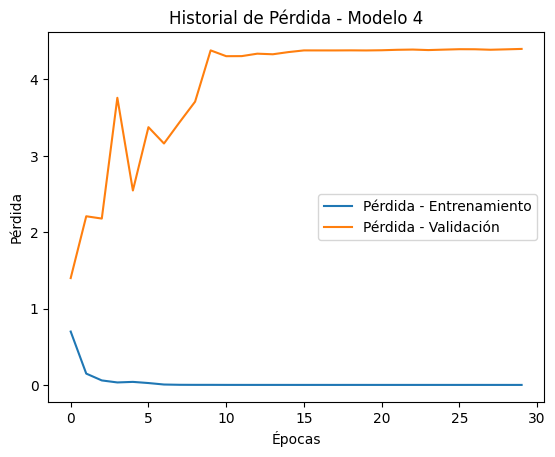


Matriz de Confusión:


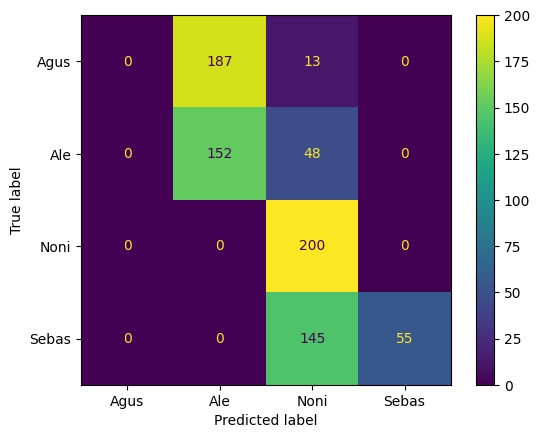



Modelo 5:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='relu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5386
Recall: 0.6638

Graficando historial de entrenamiento...


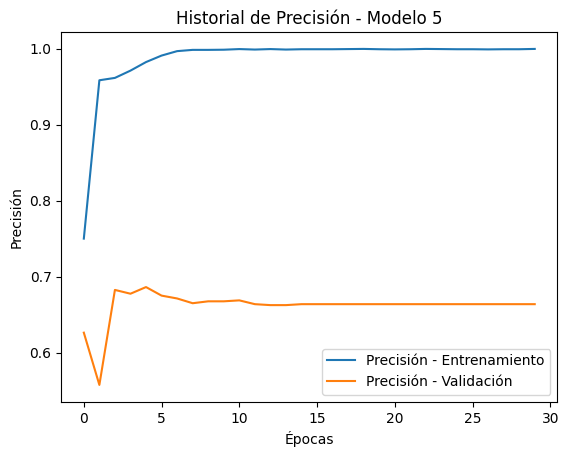

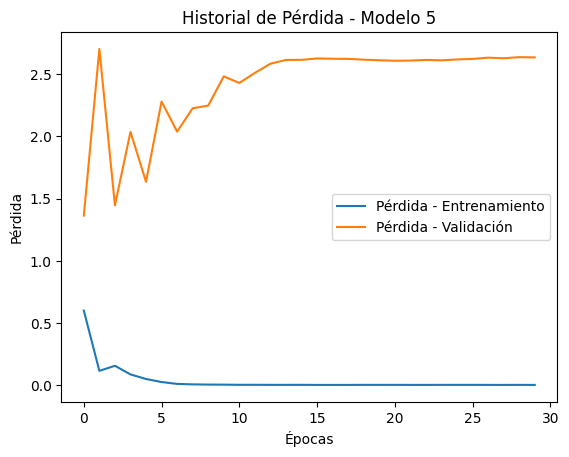


Matriz de Confusión:


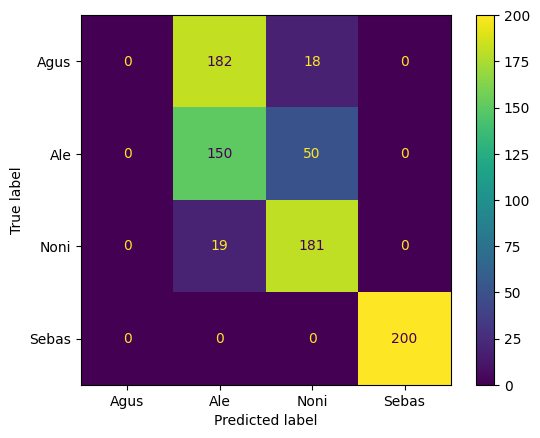



Modelo 6:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='prelu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.4536
Recall: 0.4125

Graficando historial de entrenamiento...


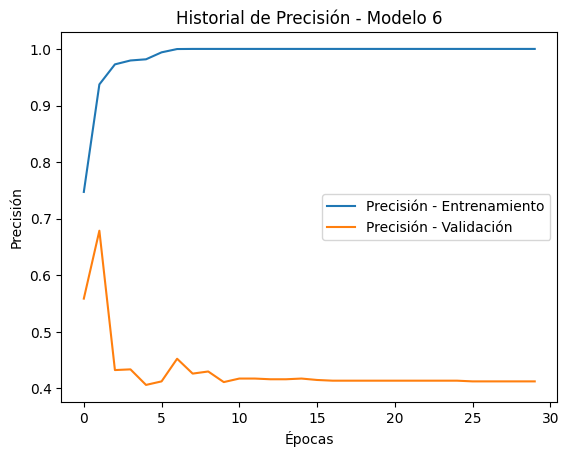

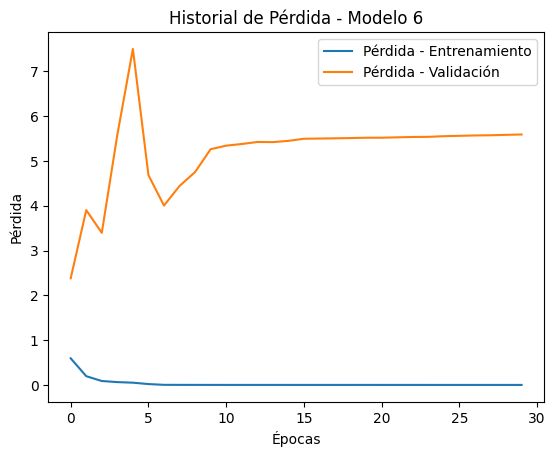


Matriz de Confusión:


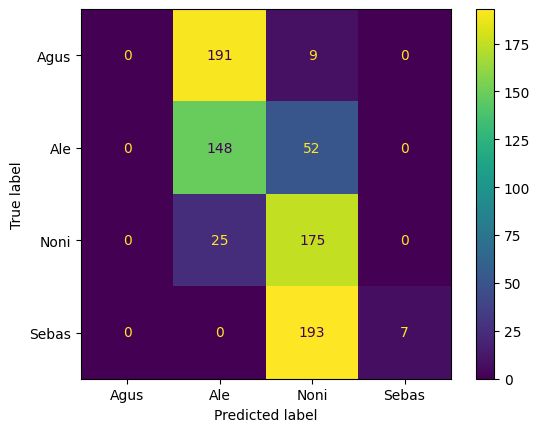



Modelo 7:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.4863
Recall: 0.5787

Graficando historial de entrenamiento...


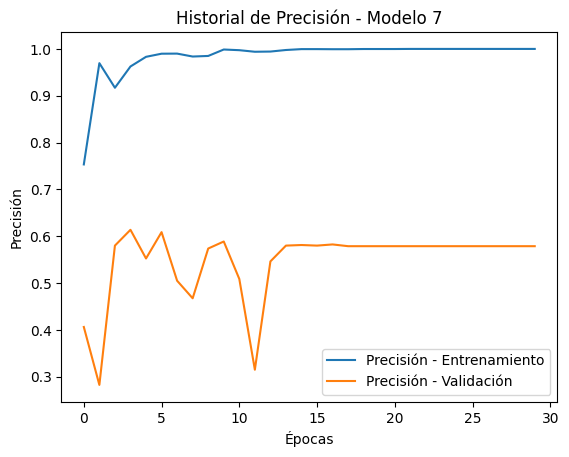

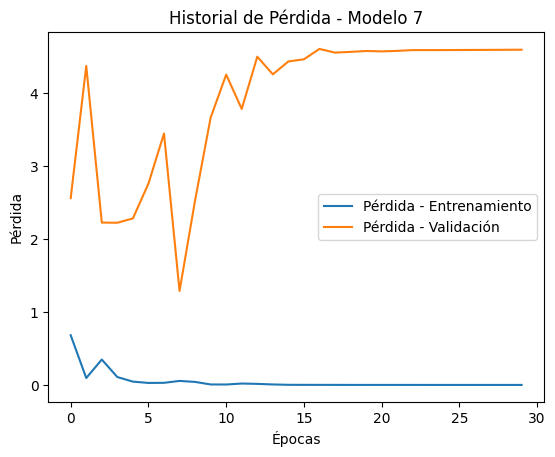


Matriz de Confusión:


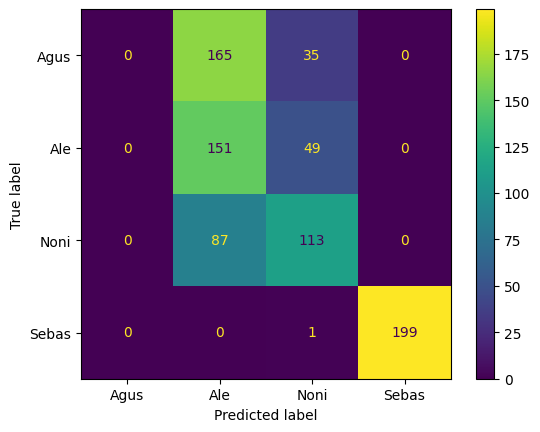



Modelo 8:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5178
Recall: 0.6512

Graficando historial de entrenamiento...


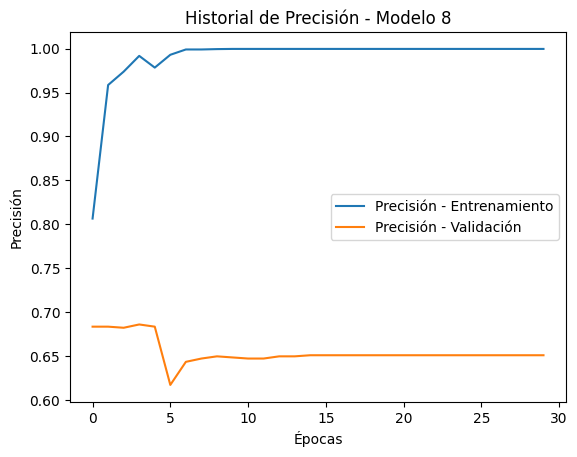

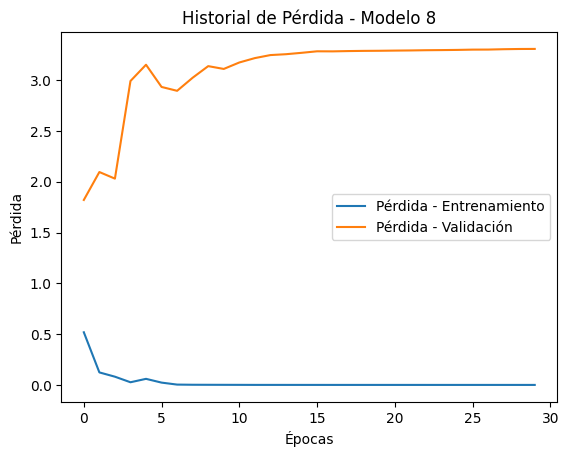


Matriz de Confusión:


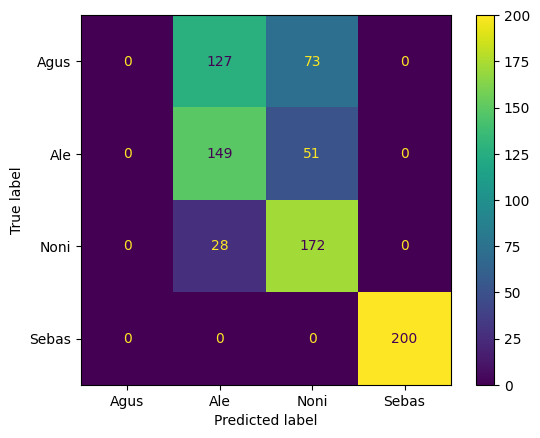



Modelo 9:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2303
Recall: 0.4575

Graficando historial de entrenamiento...


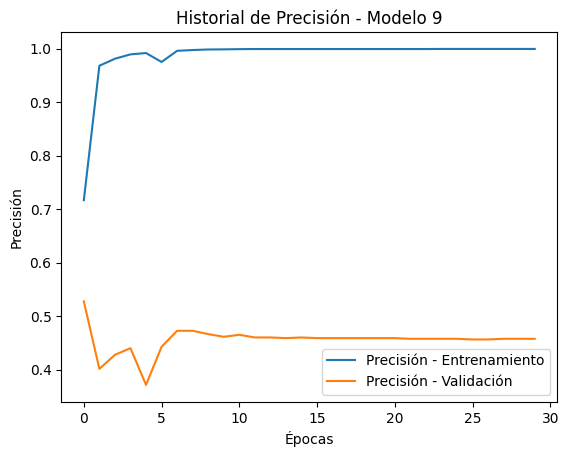

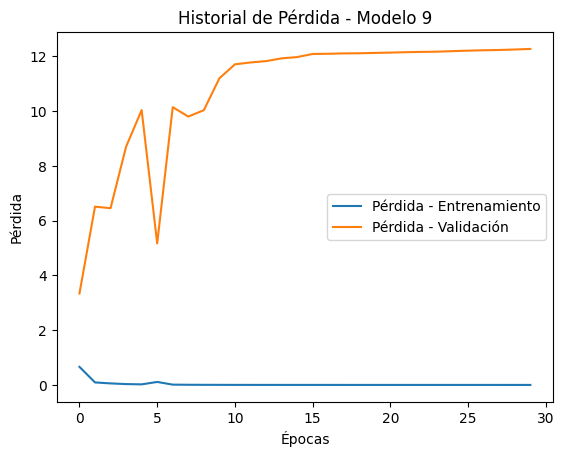


Matriz de Confusión:


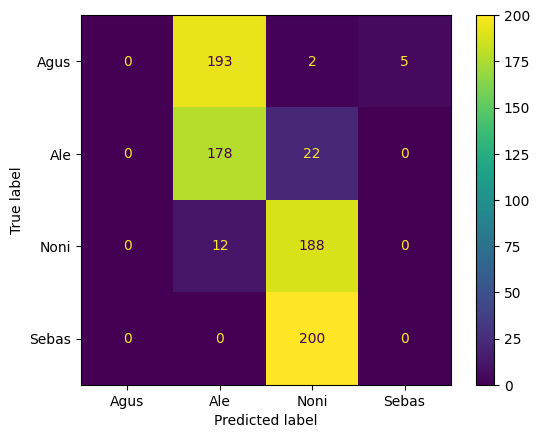



Modelo 10:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5411
Recall: 0.6625

Graficando historial de entrenamiento...


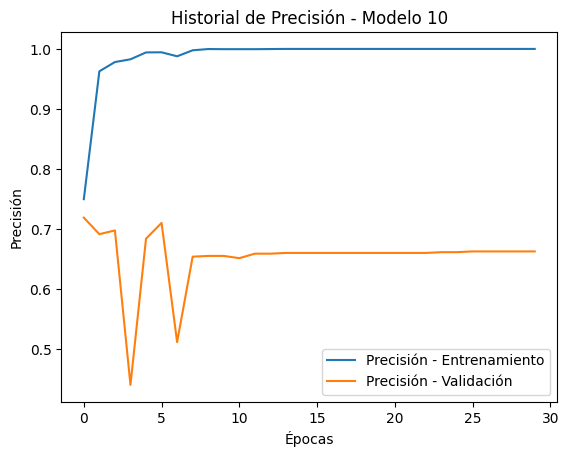

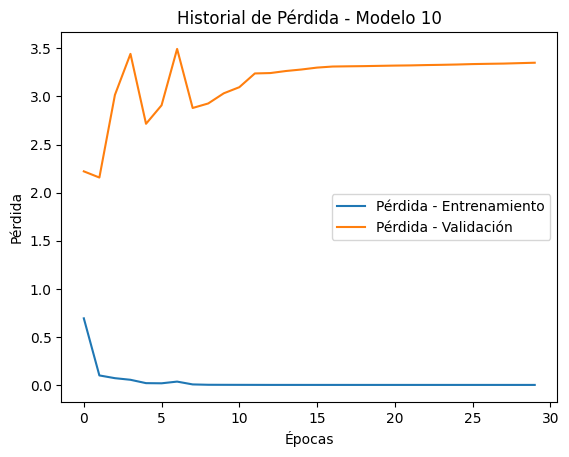


Matriz de Confusión:


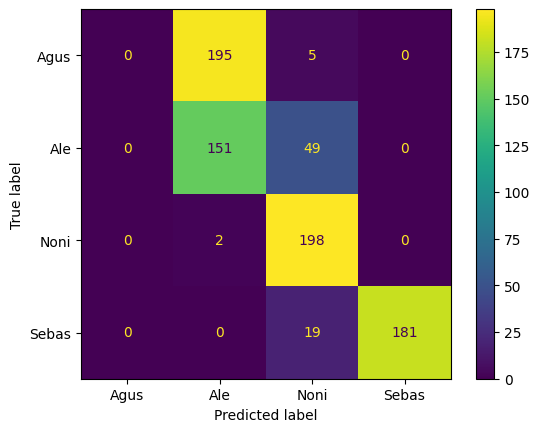

In [26]:
def mostrar_configuracion(configuracion):
    salida = []
    salida.append("Capas Ocultas:")
    for i, capa in enumerate(configuracion["capas_ocultas"]):
        salida.append(f"  Capa {i + 1}: {capa['neuronas']} neuronas, activación='{capa['activation']}', dropout={capa.get('dropout', 0)}")
    salida.append(f"Learning Rate: {configuracion['learning_rate']}")
    salida.append(f"Factor de Reducción: {configuracion['factor_reduccion']}")
    salida.append(f"Salida: {configuracion['output']['neuronas']} neuronas, activación='{configuracion['output']['activation']}'")
    return "\n".join(salida)

def mostrar_todo_dataframe(df, labels):
    for index, fila in df.iterrows():
        print(f"Modelo {index + 1}:")
        print("-" * 40)
        
        print("Configuración del modelo:")
        print(mostrar_configuracion(fila["configuracion"]))
        
        print("\nMétricas del modelo:")
        print(f"Precisión: {fila['precision']:.4f}")
        print(f"Recall: {fila['recall']:.4f}")
        
        historial = fila["historial"]
        print("\nGraficando historial de entrenamiento...")
        plt.plot(historial["accuracy"], label="Precisión - Entrenamiento")
        plt.plot(historial["val_accuracy"], label="Precisión - Validación")
        plt.title(f"Historial de Precisión - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Precisión")
        plt.legend()
        plt.show()

        plt.plot(historial["loss"], label="Pérdida - Entrenamiento")
        plt.plot(historial["val_loss"], label="Pérdida - Validación")
        plt.title(f"Historial de Pérdida - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida")
        plt.legend()
        plt.show()

        print("\nMatriz de Confusión:")
        cm_display = ConfusionMatrixDisplay(fila["matriz_confusion"], display_labels=labels)
        cm_display.plot()
        plt.show()

        print("\n" + "=" * 50 + "\n")

mostrar_todo_dataframe(df_resultados, labels=labels)
